In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Mortality Rate Correction

In [3]:
date = '03-28-2020'
data = pd.read_csv('data/csse_covid_19_daily_reports/'+date+'.csv', sep=',')

In [4]:
def get_mortality_rates(data):
    print('Using mortality rate = deaths / closed cases')
    mortality = list()
    for index, row in data.iterrows():
        try:
            mortality.append(float(row['Deaths'])*100.0/(row['Deaths'] + row['Recovered']))
        except:
            mortality.append(0.0)
    return np.array(mortality)

In [5]:
def get_death_ratio(data):
    print('Using mortality rate = deaths / total confirmed cases')
    mortality = list()
    for index, row in data.iterrows():
        try:
            mortality.append(float(row['Deaths'])*100.0/row['Confirmed'])
        except:
            mortality.append(0.0)
    return np.array(mortality)

In [6]:
def plot_country_mortality(data, func, k=10):
    countries = np.unique(data['Country_Region'])

#     data = data.drop(['Province/State', 'Last Update', 'Latitude', 'Longitude'], axis=1)
    country_wise_data = pd.DataFrame()

    country_wise_data = country_wise_data.append({'Country': 'Worldwide', 
                                                'Confirmed': data['Confirmed'].sum(),
                                                'Deaths': data['Deaths'].sum(), 
                                                'Recovered': data['Recovered'].sum()},
                                                ignore_index=True)
    
    outside_china = data.loc[data['Country_Region'] != 'China']
    country_wise_data = country_wise_data.append({'Country': 'World - Outside China', 
                                                'Confirmed': outside_china['Confirmed'].sum(),
                                                'Deaths': outside_china['Deaths'].sum(), 
                                                'Recovered': outside_china['Recovered'].sum()},
                                                ignore_index=True)
    


    for cunt in countries:
        entries = data.loc[data['Country_Region'] == cunt]

        country_wise_data = country_wise_data.append({'Country': cunt, 
                                                'Confirmed': entries['Confirmed'].sum(),
                                                'Deaths': entries['Deaths'].sum(), 
                                                'Recovered': entries['Recovered'].sum()},
                                                ignore_index=True)
        
    country_wise_data['Mortality'] = func(country_wise_data)
    sorted_data = country_wise_data.sort_values(by=['Confirmed', 'Mortality'], 
                                                ascending=False).head(k+1)

    plt.figure(figsize=(0.75*k,6))
    plt.bar(range(k+1), sorted_data['Mortality'])
    plt.xticks(range(k+1), sorted_data['Country'], rotation=90)
    plt.ylabel('Mortality Rate')
    plt.title('Mortality rate of top '+str(k)+' countries with most confirmed cases as of '+date)

    [plt.text(i-0.35, v+0.25, '{:.1f}'.format(v)) for i, v in enumerate(sorted_data['Mortality'])]
    plt.show()

    return sorted_data['Country'].values

Using mortality rate = deaths / closed cases


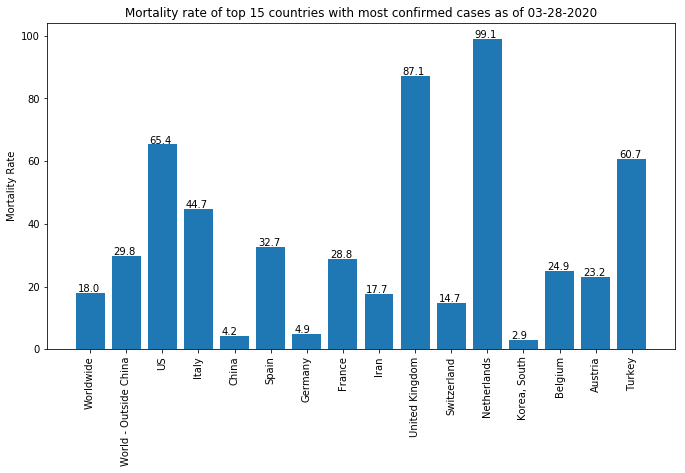

In [7]:
top_countries = plot_country_mortality(data, get_mortality_rates, 15)

Using mortality rate = deaths / total confirmed cases


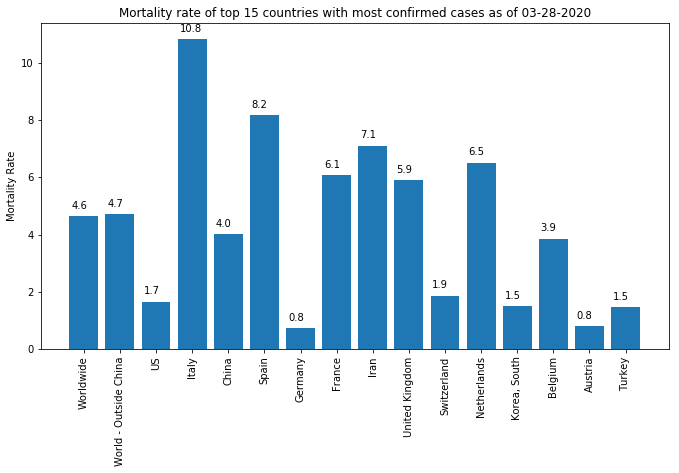

In [8]:
top_countries = plot_country_mortality(data, get_death_ratio, 15)

# Spread Rate

In [9]:
path = 'data/csse_covid_19_time_series/'

# laod data
data_Confirmed = pd.read_csv(os.path.join(path, 'time_series_covid19_confirmed_global.csv'))
data_Deaths = pd.read_csv(os.path.join(path, 'time_series_covid19_deaths_global.csv'))
data_Recovered = pd.read_csv(os.path.join(path, 'time_series_covid19_recovered_global.csv'))

# remove extra fields
data_Confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
data_Deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
data_Recovered.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)

In [10]:
def get_time_series(data, country='Pakistan', days=-1):
    data = data.loc[data['Country/Region'] == country]

    start = False
    cum_cases = list()

    for col in data:
        if data.dtypes[col] != "object":
            cases = data[col].sum()
            
            if cases == 0 and not start:
                continue
            elif not start:
                start = True

            if start:
                cum_cases.append(cases)
            
            if days != -1 and len(cum_cases) == days:
                break
    
    return cum_cases

In [11]:
def plot_country_spread(data, countries, prefix, days=-1):
    plt.figure(figsize=(10,7))
    
    for cunt in countries:
        stats = get_time_series(data, cunt, days)
        plt.plot(range(len(stats)), stats, label=cunt)
        
    plt.ylabel(prefix.capitalize()+' Reported')
    plt.xlabel('Days since first case reported')
    
    plt.legend()
    
    if days == -1:
        plt.title('Comparison of COVID-19 '+prefix)
    else:
        plt.title('Comparison of COVID-19 '+prefix+' for first '+str(days)+' days')

    plt.show()

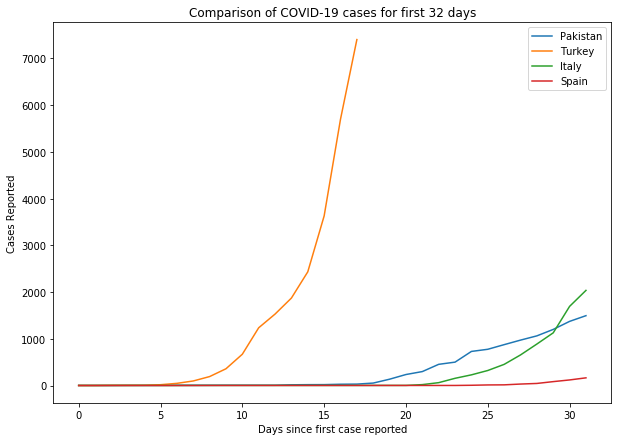

In [38]:
plot_country_spread(data_Confirmed, ['Pakistan', 'Turkey', 'Italy', 'Spain'], 'cases', 32)

In [47]:
top_countries = ['Italy', 'US', 'Spain', 'Germany', 
                 'United Kingdom', 'France', 'Iran', 'Switzerland']

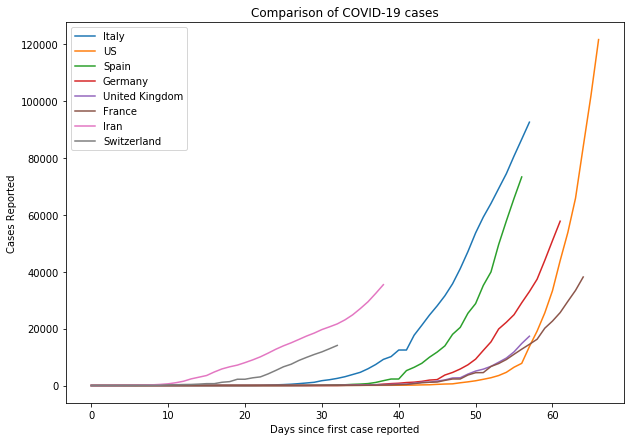

In [48]:
plot_country_spread(data_Confirmed, top_countries, 'cases')

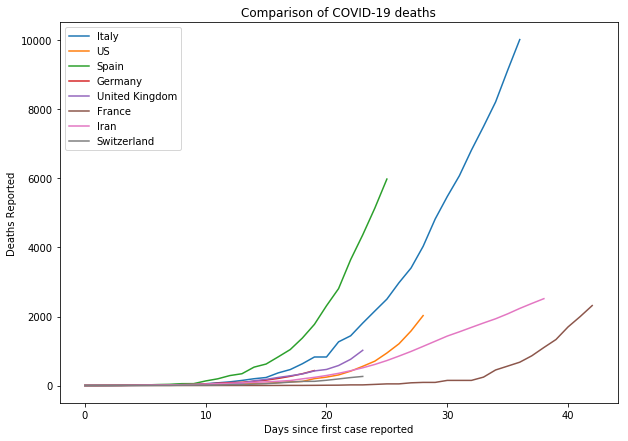

In [49]:
plot_country_spread(data_Deaths, top_countries, 'deaths')

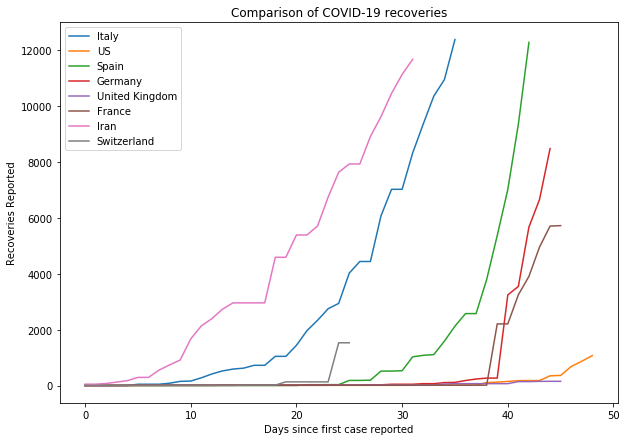

In [50]:
plot_country_spread(data_Recovered, top_countries, 'recoveries')

In [16]:
# number of days to reach a certain number of cases after first case
def days_to_cases(data, country, max_cases):
    data = data.loc[data['Country/Region'] == country]
    start = False
    
    days = 0
    
    for col in data:
        
        if data.dtypes[col] != "object":
            cases = data[col].sum()            
            
            if cases == 0 and not start:
                continue
            elif not start:
                start = True

            if start:
                days += 1
                
            if cases >= max_cases:
                break
                
    return days

In [17]:
def plot_cases_climb(data, countries, max_cases, prefix):
    plt.figure(figsize=(0.75*len(countries),6))
               
    values = list()
    for cunt in countries:
        values.append(days_to_cases(data, cunt, max_cases))
               
    plt.bar(range(len(countries)), values)
    plt.xticks(range(len(countries)), countries, rotation=90)
    plt.ylabel('Days since first case reported')
    
    plt.title('Comparison of number of days taken by countries to reach '+str(max_cases)+' '+prefix)

    [plt.text(i-0.15, v+0.25, '{:d}'.format(v)) for i, v in enumerate(values)]
    plt.show()

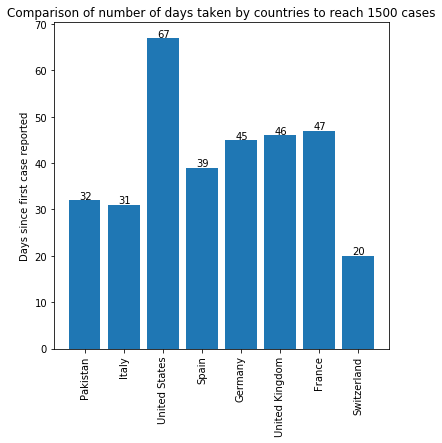

In [19]:
plot_cases_climb(data_Confirmed, top_countries, 1500, 'cases')

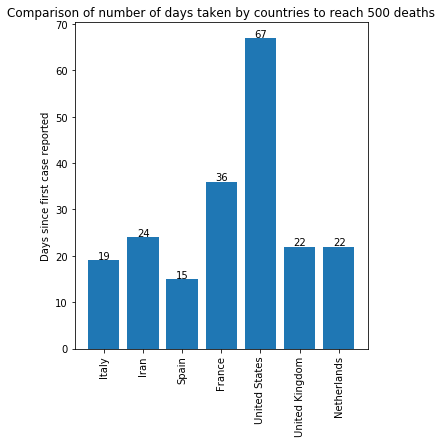

In [20]:
plot_cases_climb(data_Deaths, ['Italy', 'Iran', 'Spain', 'France', 'United States', 'United Kingdom', 'Netherlands'], 500, 'deaths')

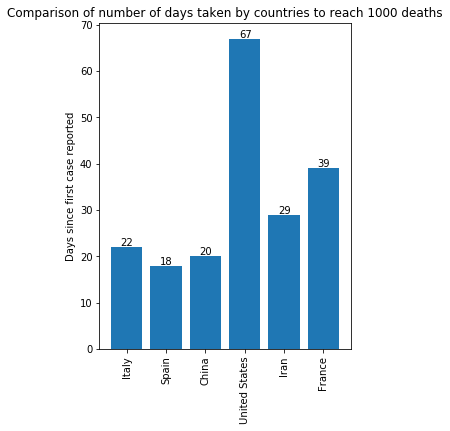

In [21]:
plot_cases_climb(data_Deaths, ['Italy', 'Spain', 'China', 'United States', 'Iran', 'France'], 1000, 'deaths')

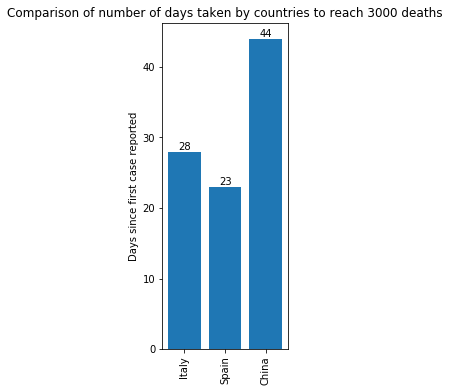

In [22]:
plot_cases_climb(data_Deaths, ['Italy', 'Spain', 'China'], 3000, 'deaths')

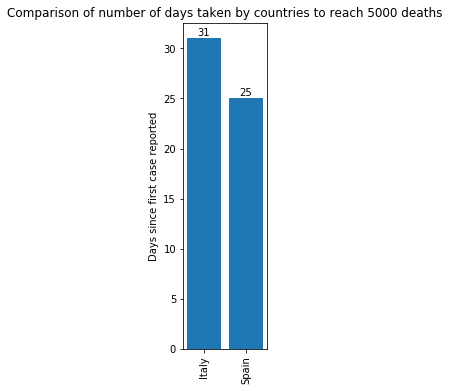

In [23]:
plot_cases_climb(data_Deaths, ['Italy', 'Spain'], 5000, 'deaths')

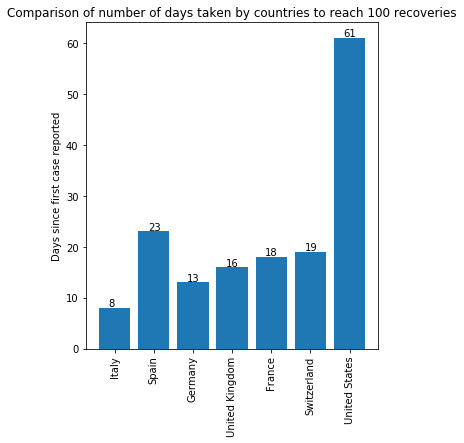

In [16]:
plot_cases_climb(data_Recovered, top_countries[1:], 100, 'recoveries')